In [74]:
import cv2
import numpy as np
from imutils import perspective
from imutils import contours
import numpy as np
import imutils
import cv2
import os
import plotly
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from skimage import data, filters, measure, morphology
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# Load datasets

In [75]:
class Data:
    def __init__(self, path):
        self.path = path
        self.name = None
        self.class_color_mapping = None
        self.class_names = None
        self.imgs = None
        self.instances_map = None
        self.classification_map = None
        self.counts = None
        self.properties = ['area', 'eccentricity', 'perimeter', 'orientation', 'axis_major_length', 'axis_minor_length', 'num_pixels']
        self.relevant_instances = None
        self.all_instances = None

    def get_all_instances(self):
        dfs = [self.instance_properties(idx) for idx in self.relevant_instances]
        all_instances = pd.concat(dfs, ignore_index=True)
        all_instances['dataset'] = self.name
        return all_instances

    def instance_properties(self, n):
        image = self.imgs[n]
        inst_map = self.instances_map[n]
        class_map = self.classification_map[n]

        # Generating unique colours for each class associated with an instance
        mask = inst_map != 0
        instance_ids = inst_map[mask]
        class_ids = class_map[mask]
        instance_class_mapping = dict(zip(instance_ids, class_ids))
        instance_name_mapping = dict(zip(instance_ids, [self.class_names[id] for id in class_ids]))
        table = measure.regionprops_table(inst_map, image, self.properties) #Total properties table
        table['class'] = instance_class_mapping.values()
        table['class_name'] = instance_name_mapping.values()
        df = pd.DataFrame(table)
        return df

    def plot_image(self, n):
        image = self.imgs[n]
        inst_map = self.instances_map[n]
        unique_instances = np.unique(inst_map)[1:]
        class_map = self.classification_map[n]

        # Generating unique colours for each class associated with an instance
        mask = inst_map != 0
        instance_ids = inst_map[mask]
        class_ids = class_map[mask]
        instance_class_mapping = dict(zip(instance_ids, class_ids))

        fig = px.imshow(image, binary_string=True)
        fig.update_traces(hoverinfo='skip') 

        properties = ['area', 'eccentricity', 'perimeter', 'orientation', 'axis_major_length', 'axis_minor_length', 'num_pixels']

        colors_used = {}
        for instance_label in unique_instances:
            mask = np.where(inst_map == instance_label, 255, 0).astype(np.uint8) # Create a mask for the current instances
            contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0] # Find contours in the mask
            props = measure.regionprops(mask, image, properties)[0] #Properties for each instance

            # Iterate through contours of the current instance
            for idx, contour in enumerate(contours):
                contour = np.squeeze(contour, axis=1) # Contour in plotly-compatible format
                y, x = contour[:, 1], contour[:, 0]
                
                hoverinfo = ''
                for prop_name in properties:
                    hoverinfo += f'<b>{prop_name}:</b> {getattr(props, prop_name):.2f}<br>' #Hoverinfo text
                
                color = self.class_color_mapping.get(instance_class_mapping[instance_label])
                colors_used[instance_class_mapping[instance_label]] = color

                # Add trace for the contour
                fig.add_trace(go.Scatter(
                    x=x, y=y, mode='lines', fill='toself',
                    line=dict(color=color), 
                    hoveron='points+fills',
                    hovertemplate=hoverinfo,
                    showlegend=False
                ))  
                
        colors_used = dict((v1, v2) for k2,v2 in colors_used.items() for k1,v1 in self.class_names.items() if k1==k2)
            
        for class_id, color in colors_used.items():
            fig.add_trace(go.Scatter(y=[None], mode='markers',
                                marker=dict(size=10, color=color[:3]+'a'+color[3:-1]+', 0.4)', line=dict(color=color, width=6)),
                                marker_symbol='diamond-wide', 
                                name=f"{class_id}",
                                ))

        fig.update_layout(
            showlegend=True,
            legend=dict(
                x=0.75,
                y=0.7,
                traceorder="normal",
                title="",
                itemsizing="constant"
            ),
            # xaxis=dict(visible=False),
            # yaxis=dict(visible=False)
        )

        plotly.io.show(fig)
    


class LizardData(Data):
    def __init__(self, path):
        super().__init__(path)
        self.path = path
        self.name = "LIZARD"
        self.class_color_mapping = {
            1: 'rgb(255, 165, 0)', # Orange
            2: 'rgb(0, 255, 0)',   # Green
            3: 'rgb(255, 0, 0)',   # Red
            4: 'rgb(0, 255, 255)', # Cyan
            5: 'rgb(0, 0, 255)',   # Blue
            6: 'rgb(255, 255, 0)', # Tellow
        }
            
        self.class_names = {
            1: 'NEU', #'Neutrophil',
            2: 'EPI', #'Epithelial',
            3: 'LYM', #'Lymphocyte',
            4: 'PLA', #'Plasma',
            5: 'EOS', #'Eosinophil',
            6: 'CON', #'Connective',
        }
        self.imgs = np.load(self.path + '\images.npy')
        self.instances_map = np.load(self.path + '\labels.npy')[..., 0]
        self.classification_map = np.load(self.path + '\labels.npy')[..., 1]
        self.counts = pd.read_csv(self.path + '\counts.csv')
        self.relevant_instances = self.get_relevant_instances()
        self.all_instances = self.get_all_instances()

    def get_relevant_instances(self):
        relevant_instances = [] # All instances that contain PLA, LYM, EOS and EPI
        for id in range(len(self.instances_map)):
            image = self.imgs[id]
            inst_map = self.instances_map[id]
            class_map = self.classification_map[id]
            mask = inst_map != 0
            class_ids = np.unique(class_map[mask])
            if all(x in class_ids for x in [2, 3, 4, 5, 6]): # Only use representative images that contain PLA, LYM, EOS and EPI cells and thus are similar to ours.
                relevant_instances.append(id)
        return relevant_instances


class LotusData(Data):
    def __init__(self, path):
        super().__init__(path)
        self.path = path
        self.name = "LOTUS"
        self.class_color_mapping = {
            1: 'rgb(0, 255, 0)',   # Green
            2: 'rgb(0, 255, 255)', # Cyan
            3: 'rgb(255, 0, 0)',   # Red
            4: 'rgb(0, 0, 255)',   # Blue
            5: 'rgb(255, 255, 0)', # Tellow
            6: 'rgb(255, 165, 0)', # Orange
        }
            
        self.class_names = {
            1: 'EPI',
            2: 'PLA',
            3: 'LYM',
            4: 'EOS',
            5: 'FIB',
            6: 'GOB',
        }

        self.imgs = self.load_images_as_arrays(os.path.join(path, 'images'))
        self.instances_map = self.load_images_as_arrays(os.path.join(path, 'masks', 'instance_indexing'))
        self.instances_map = [instance_map[:,:,0] for instance_map in self.instances_map] # Needs to be 2D array, mapping 3D grey values (a,a,a) to a.
        self.classification_map = self.load_images_as_arrays(os.path.join(path, 'masks', 'semantic_indexing'))
        self.classification_map = [classification[:,:,0] for classification in self.classification_map] # Needs to be 2D array, mapping 3D grey values (a,a,a) to a.
        self.relevant_instances = self.get_relevant_instances()
        self.all_instances = self.get_all_instances()

    def load_images_as_arrays(self, folder):
            image_arrays = []
            for filename in os.listdir(folder):
                img_path = os.path.join(folder, filename)
                if os.path.isfile(img_path) and img_path.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif')):
                    img = cv2.imread(img_path)
                    if len(img.shape) == 3:
                        # Convert BGR to RGB as OpenCV loads images in BGR format
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    image_arrays.append(img_rgb)
            return image_arrays
    
    def get_relevant_instances(self):
        relevant_instances = [] # All instances that contain PLA, LYM, EOS and EPI
        for id in range(len(self.instances_map)):
            image = self.imgs[id]
            inst_map = self.instances_map[id]
            class_map = self.classification_map[id]
            mask = inst_map != 0
            class_ids = np.unique(class_map[mask])
            #if all(x in class_ids for x in [1, 2, 3, 4, 5]): # Due to rare cell types not occuring on many synthetic images we consider all images
            relevant_instances.append(id) # Due to rare cell types not occuring on many synthetic images we consider all images
        return relevant_instances



<>:130: SyntaxWarning:

invalid escape sequence '\i'

<>:131: SyntaxWarning:

invalid escape sequence '\l'

<>:132: SyntaxWarning:

invalid escape sequence '\l'

<>:133: SyntaxWarning:

invalid escape sequence '\c'

<>:130: SyntaxWarning:

invalid escape sequence '\i'

<>:131: SyntaxWarning:

invalid escape sequence '\l'

<>:132: SyntaxWarning:

invalid escape sequence '\l'

<>:133: SyntaxWarning:

invalid escape sequence '\c'

C:\Users\ckarg\AppData\Local\Temp\ipykernel_8592\1005534179.py:130: SyntaxWarning:

invalid escape sequence '\i'

C:\Users\ckarg\AppData\Local\Temp\ipykernel_8592\1005534179.py:131: SyntaxWarning:

invalid escape sequence '\l'

C:\Users\ckarg\AppData\Local\Temp\ipykernel_8592\1005534179.py:132: SyntaxWarning:

invalid escape sequence '\l'

C:\Users\ckarg\AppData\Local\Temp\ipykernel_8592\1005534179.py:133: SyntaxWarning:

invalid escape sequence '\c'



In [76]:
lotus = LotusData(r'C:\Users\ckarg\Documents\Datasets\render_v1_7\train')
lizard = LizardData(r'C:\Users\ckarg\Documents\Datasets\HE_lizard\data')

In [77]:
for idx in lotus.relevant_instances[:5]:
    lotus.plot_image(idx)

In [78]:
for idx in lizard.relevant_instances[:5]:
    lizard.plot_image(idx)

In [79]:
lizard.all_instances

area  eccentricity  perimeter  orientation  axis_major_length  \
0       220.0      0.454605  54.384776     0.916958          17.819718   
1       215.0      0.921799  61.698485    -1.248672          26.835580   
2       193.0      0.361722  50.627417     1.064950          16.352615   
3       186.0      0.510893  48.970563    -0.354041          16.627401   
4       177.0      0.957974  65.112698     0.529935          30.047780   
...       ...           ...        ...          ...                ...   
186637  152.0      0.929346  53.112698     0.659967          23.408079   
186638   81.0      0.597922  30.727922     1.558500          11.345227   
186639  113.0      0.762240  38.384776     0.448766          14.981870   
186640   61.0      0.468365  25.899495     1.181583           9.353561   
186641   49.0      0.564604  23.899495    -0.998530           8.720090   

        axis_minor_length  num_pixels  class class_name dataset  
0               15.871898         220      4        PLA  LIZARD  
1               10.403317         215      2        EPI  LIZARD  
2               15.245315         193      2        EPI  LIZARD  
3               14.293648         186      6        CON  LIZARD  
4                8.619328         177      2        EPI  LIZARD  
...                   ...         ...    ...        ...     ...  
186637           8.642496         152      4        PLA  LIZARD  
186638           9.093817          81      3        LYM  LIZARD  
186639           9.697678         113      2        EPI  LIZARD  
186640           8.264199          61      6        CON  LIZARD  
186641           7.197229          49      6        CON  LIZARD  

[186642 rows x 10 columns]

In [80]:
print(len(lotus.relevant_instances))
lotus.all_instances

1792


area  eccentricity   perimeter  orientation  axis_major_length  \
0       539.0      0.441545   85.597980     0.835075          28.027325   
1       374.0      0.827889   75.112698    -1.345481          29.490418   
2       539.0      0.741778   88.769553     0.264211          32.588605   
3       342.0      0.651046   69.941125    -1.474465          24.057390   
4       573.0      0.615714   89.012193    -0.015762          30.690348   
...       ...           ...         ...          ...                ...   
151786  628.0      0.903113  103.597980    -1.408406          43.342888   
151787  444.0      0.857781   82.183766    -1.260091          33.165234   
151788  169.0      0.487939   46.041631    -1.236776          15.710678   
151789  510.0      0.830026   86.769553     1.276874          34.235239   
151790  405.0      0.779620   75.012193    -0.779324          28.738497   

        axis_minor_length  num_pixels  class class_name dataset  
0               25.147218         539      1        EPI   LOTUS  
1               16.540941         374      1        EPI   LOTUS  
2               21.855396         539      1        EPI   LOTUS  
3               18.260476         342      1        EPI   LOTUS  
4               24.183056         573      1        EPI   LOTUS  
...                   ...         ...    ...        ...     ...  
151786          18.611593         628      1        EPI   LOTUS  
151787          17.047418         444      3        LYM   LOTUS  
151788          13.713504         169      1        EPI   LOTUS  
151789          19.093832         510      4        EOS   LOTUS  
151790          17.997572         405      3        LYM   LOTUS  

[151791 rows x 10 columns]

In [84]:
# Convert pixel measures to microns

# Note: Lizard is 0.5 microns per pixel, whereas Lotus is 0.25 microns per pixel

# Lizard
lizard.all_instances['area_in_microns'] = lizard.all_instances['area'] * 0.5 * 0.5
lizard.all_instances['axis_major_length_in_microns'] = lizard.all_instances['axis_major_length'] * 0.5
lizard.all_instances['axis_minor_length_in_microns'] = lizard.all_instances['axis_minor_length'] * 0.5

# Lotus
lotus.all_instances['area_in_microns'] = lotus.all_instances['area'] * 0.25 * 0.25
lotus.all_instances['axis_major_length_in_microns'] = lotus.all_instances['axis_major_length'] * 0.25
lotus.all_instances['axis_minor_length_in_microns'] = lotus.all_instances['axis_minor_length'] * 0.25


 Number of relevant images in Lizard dataset: 1203
 Number of relevant images in Lotus dataset: 1792


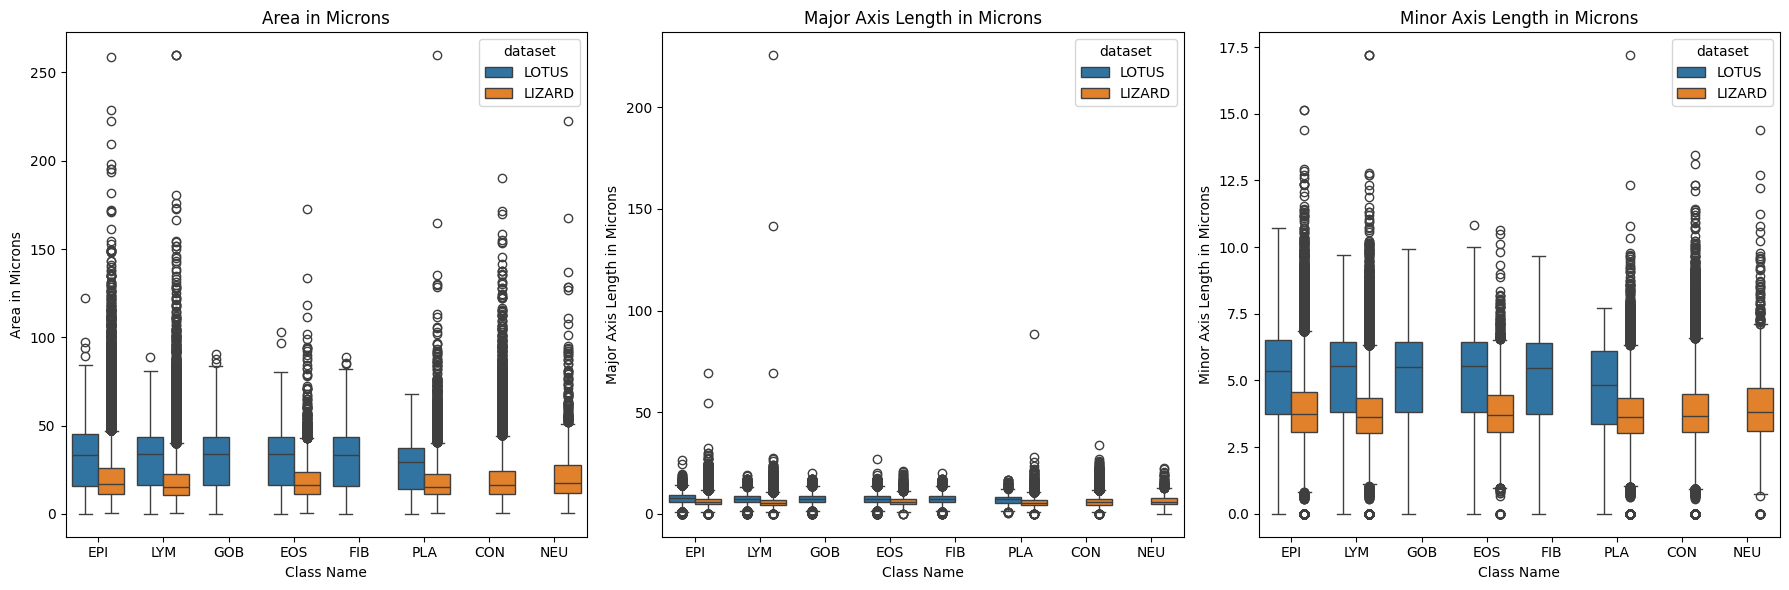

In [89]:
# Compare statistics
total_dfs = [lotus.all_instances, lizard.all_instances]

summary = pd.concat(total_dfs)
num_images_lizard = len(lizard.relevant_instances)
num_images_lotus = len(lotus.relevant_instances)
print(f" Number of relevant images in Lizard dataset: {num_images_lizard}")
print(f" Number of relevant images in Lotus dataset: {num_images_lotus}")

# create grouped boxplot 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create a 1x3 grid of subplots

# Plot for 'area_in_microns'
sns.boxplot(x='class_name', y='area_in_microns', hue='dataset', data=summary, ax=axes[0])
axes[0].set_title('Area in Microns')
axes[0].set_ylabel('Area in Microns')
axes[0].set_xlabel('Class Name')

# Plot for 'axis_major_length_in_microns'
sns.boxplot(x='class_name', y='axis_major_length_in_microns', hue='dataset', data=summary, ax=axes[1])
axes[1].set_title('Major Axis Length in Microns')
axes[1].set_ylabel('Major Axis Length in Microns')
axes[1].set_xlabel('Class Name')

# Plot for 'axis_minor_length_in_microns'
sns.boxplot(x='class_name', y='axis_minor_length_in_microns', hue='dataset', data=summary, ax=axes[2])
axes[2].set_title('Minor Axis Length in Microns')
axes[2].set_ylabel('Minor Axis Length in Microns')
axes[2].set_xlabel('Class Name')

# Adjust layout
plt.tight_layout()
plt.show()

# Count ratios

In [107]:
df = lizard.all_instances
# Count rows per class
df = df.groupby('class_name', as_index=False)['area'].count()
df['count'] = df['area']
df['rel_count'] = df['count'] / len(lizard.relevant_instances)
df['ratio'] = df['count'] / df['count'].sum()
print(f"Lizard datatset - cell counts in {len(lizard.relevant_instances)} images:")
print(df[['class_name', 'count', 'rel_count', 'ratio']])

Lizard datatset - cell counts in 1203 images:
  class_name  count  rel_count     ratio
0        CON  40990  34.073150  0.219618
1        EOS   3260   2.709892  0.017467
2        EPI  73390  61.005819  0.393213
3        LYM  51589  42.883624  0.276406
4        NEU   1700   1.413134  0.009108
5        PLA  15713  13.061513  0.084188


In [108]:
df = lotus.all_instances
# Count rows per class
df = df.groupby('class_name', as_index=False)['area'].count()
df['count'] = df['area']
df['rel_count'] = df['count'] / len(lotus.relevant_instances)
df['ratio'] = df['count'] / df['count'].sum()
print(f"Lotus datatset - cell counts in {len(lotus.relevant_instances)} images:")
print(df[['class_name', 'count', 'rel_count', 'ratio']])

Lotus datatset - cell counts in 1792 images:
  class_name  count  rel_count     ratio
0        EOS  32381  18.069754  0.213326
1        EPI  67740  37.801339  0.446272
2        FIB  13212   7.372768  0.087041
3        GOB  19147  10.684710  0.126141
4        LYM  18621  10.391183  0.122675
5        PLA    690   0.385045  0.004546


In [92]:
#Get median per column
print(np.median(total_counts, axis=0))
# Get mean
print(np.mean(total_counts, axis=0))
# Get std
print(np.std(total_counts, axis=0))

40990.0
36988.4
25077.936187812586


## Result:

The above first-glance observation shows that we can assume a ratio of ca (25, 12, 2) for (LYM, PLA, EOS). Connective tissue does include FIB but not exclusively, so we should not use the numbers here.
Due to the long shape FIB are difficult to place densely into the tissue, so we should use a low ratio for these, maybe similar or less than EOS.

Hence we propose a (unscaled) ratio of (12, 25, 2, 1) for (PLA, LYM, EOS, FIB)

# NUCLEI SCALES

In [ ]:
all_major_axes = []
for idx in range(N):
    df = instance_properties(relevant_instances[idx])
    # Count rows per class
    df = df.groupby('class', as_index=False)['axis_major_length'].max()
    # Remove class 1 if present in table
    if 1 in df['class'].values:
        df = df[df['class'] != 1]
    # Get area column as list
    major_axes = np.array(df['axis_major_length'])
    all_major_axes.append(major_axes)
all_major_axes = np.array(all_major_axes)
all_major_axes

array([[40.18124644, 39.91770462, 42.75912694, 36.15243143],
       [38.89800417, 38.26374983, 37.47960135, 35.42786062],
       [33.86580388, 40.66341544, 56.11174577, 59.9398227 ],
       [53.38923405, 68.33408486, 37.20922748, 44.57505311],
       [43.06492497, 56.20262403, 40.69503111, 38.97405395],
       [34.8227225 , 42.20691467, 41.61394827, 39.87652841],
       [34.84226305, 54.63700759, 66.04172545, 57.95387431],
       [39.74888656, 49.85725635, 40.50634507, 55.02754215],
       [33.77459205, 44.55139068, 37.52977047, 55.22658791],
       [43.27110226, 38.55496498, 34.77051495, 44.44614516],
       [64.21107975, 38.4335986 , 39.30151067, 65.74866095],
       [47.99870559, 53.76236821, 37.50027786, 37.61891995],
       [41.59798931, 43.95093328, 44.34694133, 33.19272892],
       [41.57515375, 38.13994739, 37.54046105, 36.66274628],
       [46.75142082, 66.42602721, 46.71491045, 66.86392679],
       [57.55009598, 49.46961174, 40.99363211, 49.90350481],
       [54.48656983, 62.

In [ ]:
all_min_axes = []
for idx in range(N):
    df = instance_properties(relevant_instances[idx])
    # Count rows per class
    df = df.groupby('class', as_index=False)['axis_minor_length'].max()
    # Remove class 1 if present in table
    if 1 in df['class'].values:
        df = df[df['class'] != 1]
    # Get area column as list
    min_axes = np.array(df['axis_minor_length'])
    all_min_axes.append(min_axes)
all_min_axes = np.array(all_min_axes)
all_min_axes

array([[28.17952658, 29.14456529, 30.6282098 , 26.56258587],
       [29.4794728 , 32.07553228, 25.06759161, 31.89759301],
       [29.60743565, 30.40257129, 31.22371919, 28.57228423],
       [31.59456027, 32.79661082, 29.90320902, 32.34030196],
       [31.24279614, 30.01000515, 31.75139143, 30.54135745],
       [25.49921405, 32.16085685, 30.25434451, 30.61221206],
       [26.08014323, 27.69409189, 26.7277691 , 26.51179792],
       [30.46938365, 30.21507493, 29.31481304, 31.93786994],
       [29.52112835, 33.87841192, 29.12600169, 25.75113602],
       [31.47768324, 31.39959926, 31.57528748, 33.35918871],
       [28.5487567 , 30.93425105, 28.48118876, 29.64382549],
       [29.63448272, 30.87550543, 30.54921293, 28.25789461],
       [34.53924434, 32.42784925, 26.23330812, 23.9688088 ],
       [30.10742371, 31.32785882, 30.53683776, 30.95525765],
       [32.53523754, 30.73653591, 31.41252442, 28.74990339],
       [33.8822622 , 23.18563671, 30.87264408, 24.79397387],
       [25.14166087, 29.

In [ ]:
# Maximal minor axes
print("Minor axes:\n")
# Get 75th percentile
print(f"75th percentile: {np.percentile(all_min_axes, 75, axis=0)}")
#Get median per column
print(f"Median: {np.median(all_min_axes, axis=0)}")
# Get mean
print(f"Mean: {np.mean(all_min_axes, axis=0)}")
# Get std
print(f"Std: {np.std(all_min_axes, axis=0)}")

Minor axes:

75th percentile: [31.09095224 32.00518607 30.79263212 31.52408603]
Median: [29.72184087 30.7246459  29.30940116 30.01140589]
Mean: [29.24941406 30.49900475 28.82210314 29.77483186]
Std: [2.99519861 2.19073226 2.81863659 2.75973464]


In [ ]:
# Maximal major axes
print("Major axes:\n")
# Get 75th percentile
print(f"75th percentile: {np.percentile(all_major_axes, 75, axis=0)}")
#Get median per column
print(f"Median: {np.median(all_major_axes, axis=0)}")
# Get mean
print(f"Mean: {np.mean(all_major_axes, axis=0)}")
# Get std
print(f"Std: {np.std(all_major_axes, axis=0)}")

Major axes:

75th percentile: [47.83878825 56.31968759 43.73910437 49.80327435]
Median: [40.91065717 44.71078433 39.65974706 41.91820294]
Mean: [43.65825142 48.09310749 41.40471799 44.97948448]
Std: [8.66728433 9.05374236 7.54319191 9.01484384]


# Area distribution

In [ ]:
# Collect all area columns across all N instances per class
def get_features_for_class(target_class, feature):
    area_values = []
    for idx in range(N):
        df = instance_properties(relevant_instances[idx])
        filtered_df = df[df['class'] == target_class]
        area_values.extend(filtered_df[feature].tolist())
    return area_values

def values_above_percentile(values, percentile):
    threshold = np.percentile(values, percentile)
    return [value for value in values if value > threshold]

PERCENTILE = 95
all_features = get_features_for_class(2, 'area')
filtered_features = values_above_percentile(all_features, PERCENTILE)

filtered_features_per_class = [
    values_above_percentile(get_features_for_class(cell_type, 'area'), PERCENTILE) for cell_type in range(2, 7)]


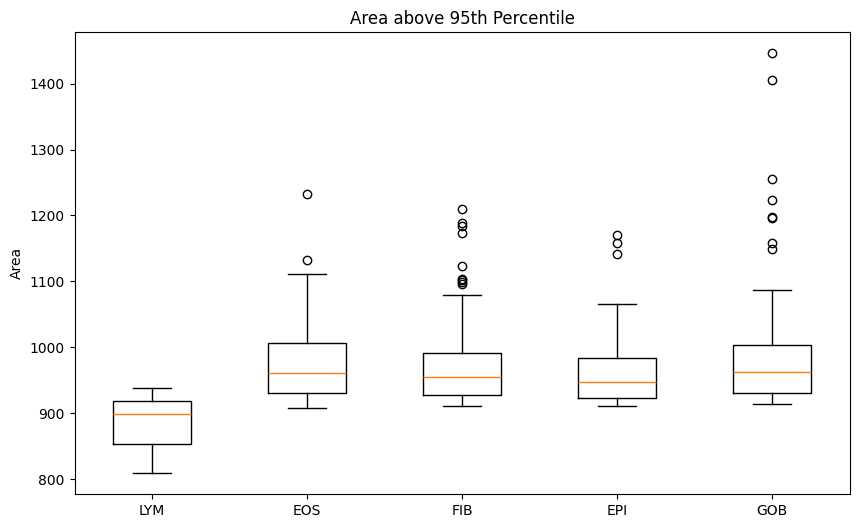

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(filtered_features_per_class)
plt.title(f'Area above {PERCENTILE}th Percentile')
#plt.xlabel('Cell Types')
plt.ylabel('Area')
plt.xticks(ticks=range(1, len(filtered_features_per_class) + 1), labels=[class_names[i+2] for i in range(len(filtered_features_per_class))])
plt.show()

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4


pandas.core.frame.DataFrame

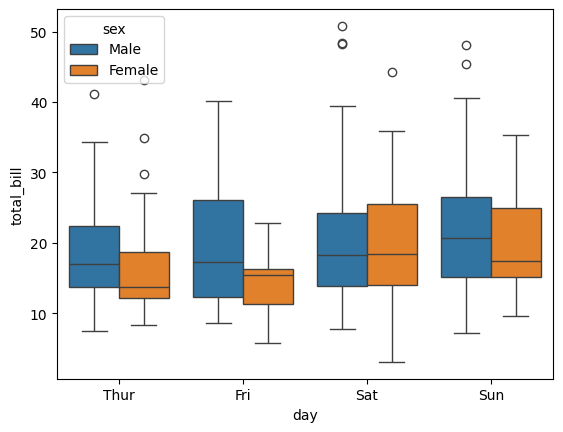

In [ ]:
# import seaborn library 
import seaborn as sns 

# load the dataset 
data = sns.load_dataset('tips') 

# view the dataset 
print(data.head(5))

# create grouped boxplot 
sns.boxplot(x = data['day'], 
			y = data['total_bill'], 
			hue = data['sex'])

type(data)


In [ ]:
df.groupby('class', as_index=False).max()
#df.groupby('class', as_index=False).min()
# df.groupby('class', as_index=False).mean()

class  axis_minor_length
0      2          25.007892
1      3          26.700450
2      4          31.219999
3      5          26.685303

In [ ]:
'''
    To avoid the time-consuming wait for the loop, it is advisable to go to the next cell and load the npy file.
'''

instances_properties_all = {prop_name: [] for prop_name in properties} #Initialized properties table of whole dataset
instances_properties_all['instances'], instances_properties_all['class'] = [],[]

for idx in tqdm(range(0, len(imgs))):
    image = imgs[idx]
    inst_map = instances_map[idx]
    unique_instances = np.unique(inst_map)[1:]
    class_map = classification_map[idx]

    # Generating unique colours for each class associated with an instance
    mask = inst_map != 0
    instance_ids = inst_map[mask]
    class_ids = class_map[mask]
    instance_class_mapping = dict(zip(instance_ids, class_ids))
    instance_class_sorted = {key:value for key, value in sorted(instance_class_mapping.items(), key=lambda item: int(item[0]))}

    props_table = measure.regionprops_table(inst_map, image, properties)
    for prop_name in properties:
        instances_properties_all[prop_name].extend(props_table[prop_name])
        
    instances_properties_all['instances'].extend(np.arange(1, len(unique_instances)+1))
    instances_properties_all['class'].extend(instance_class_mapping.values())

# np.save('/Users/vguarin/Desktop/rendered_HE/instances_properties_tables.npy', instances_properties_all) #Uncomment to sae

100%|██████████| 1792/1792 [01:00<00:00, 29.43it/s]


In [ ]:
inst = np.load('/Users/vguarin/Desktop/rendered_HE/instances_properties_tables.npy', allow_pickle=True).item()
df_all = pd.DataFrame.from_dict(inst)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/vguarin/Desktop/rendered_HE/instances_properties_tables.npy'

{1: 'Neutrophil', 2: 'Epithelial', 3: 'Lymphocyte', 4: 'Plasma', 5: 'Eosinophil', 6: 'Connective'}


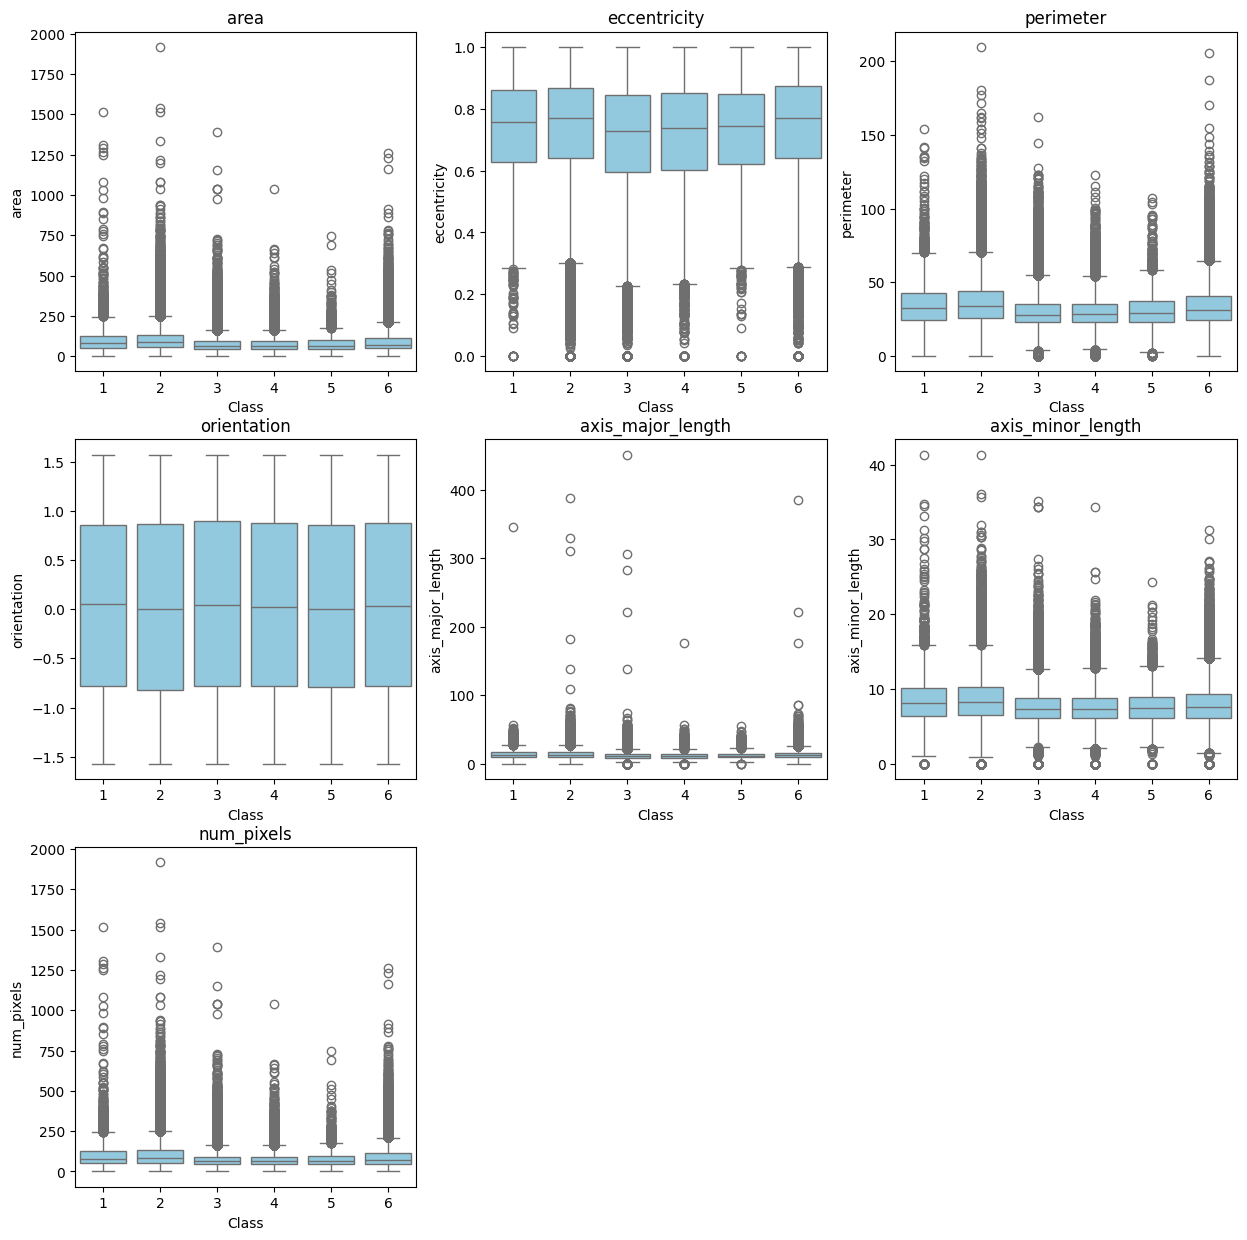

In [ ]:
num_classes = len(df_all['class'].unique())
num_rows = len(properties) // 3
if len(properties) % 3 != 0:
    num_rows += 1
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

axes = axes.flatten()
for i, prop in enumerate(properties):
    # Plot boxplots for each property
    sns.boxplot(x='class', y=prop, data=df_all, ax=axes[i], color="skyblue")
    axes[i].set_title(prop)
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel(prop)

for i in range(len(properties), len(axes)): # to hide empty subplots
    axes[i].axis('off')

print(class_names)

{1: 'Neutrophil', 2: 'Epithelial', 3: 'Lymphocyte', 4: 'Plasma', 5: 'Eosinophil', 6: 'Connective'}


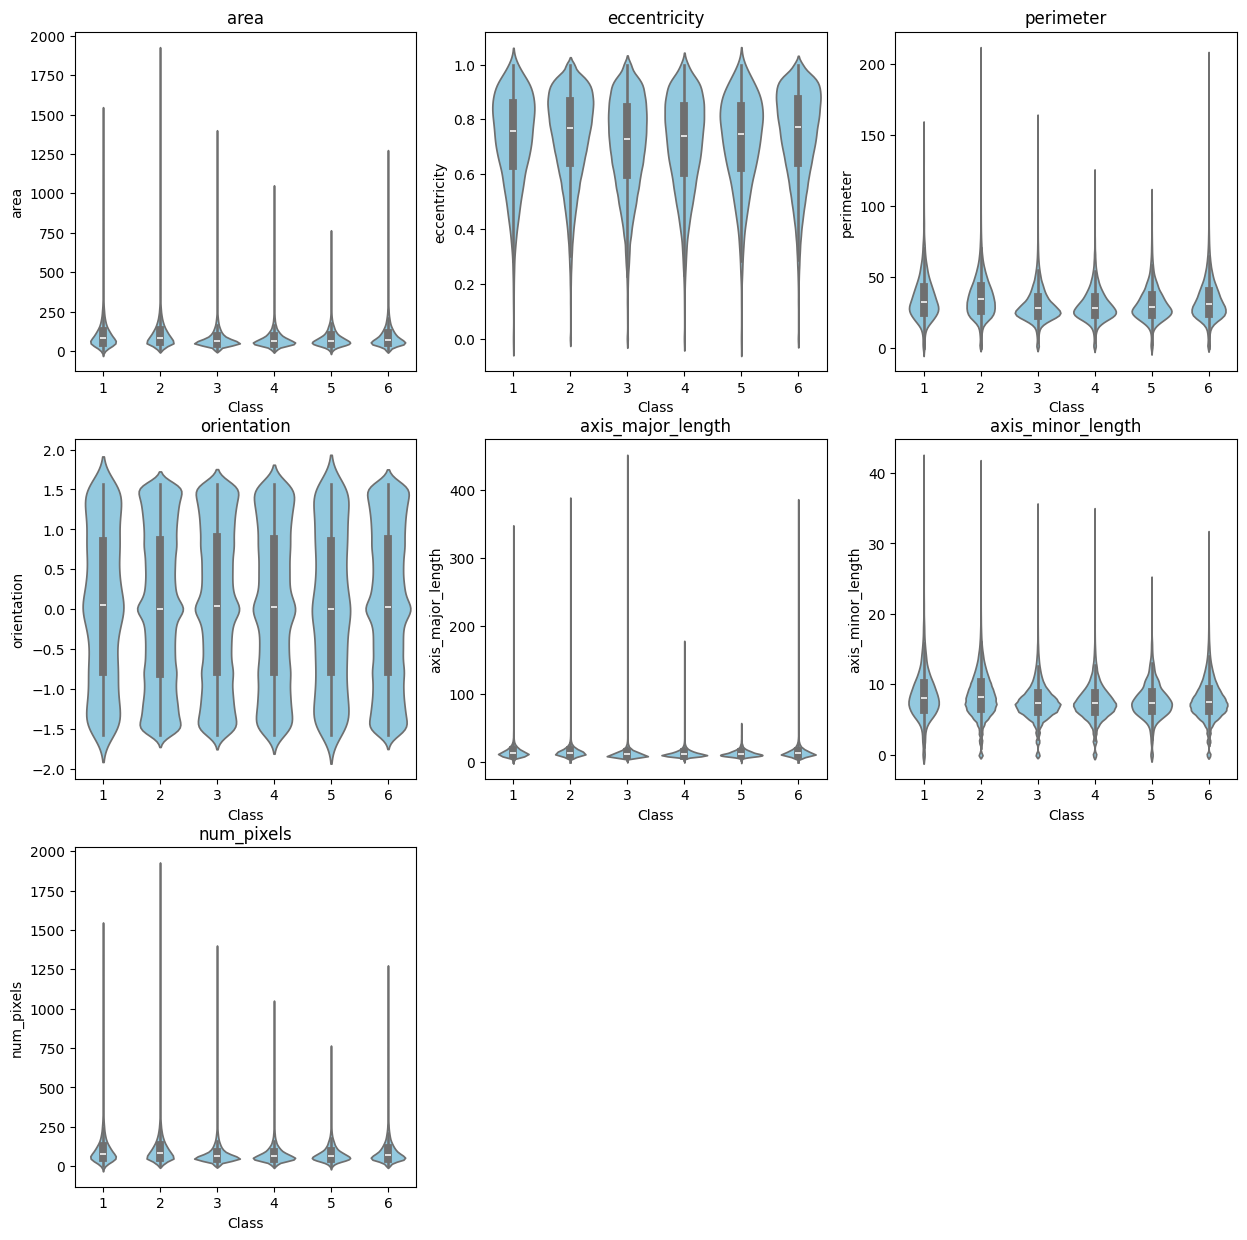

In [ ]:
num_classes = len(df_all['class'].unique())
num_rows = len(properties) // 3
if len(properties) % 3 != 0:
    num_rows += 1
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

axes = axes.flatten()
for i, prop in enumerate(properties):
    # Plot boxplots for each property
    sns.violinplot(x='class', y=prop, data=df_all, ax=axes[i], color="skyblue")
    axes[i].set_title(prop)
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel(prop)

for i in range(len(properties), len(axes)): # to hide empty subplots
    axes[i].axis('off')

print(class_names)

{1: 'Neutrophil', 2: 'Epithelial', 3: 'Lymphocyte', 4: 'Plasma', 5: 'Eosinophil', 6: 'Connective'}


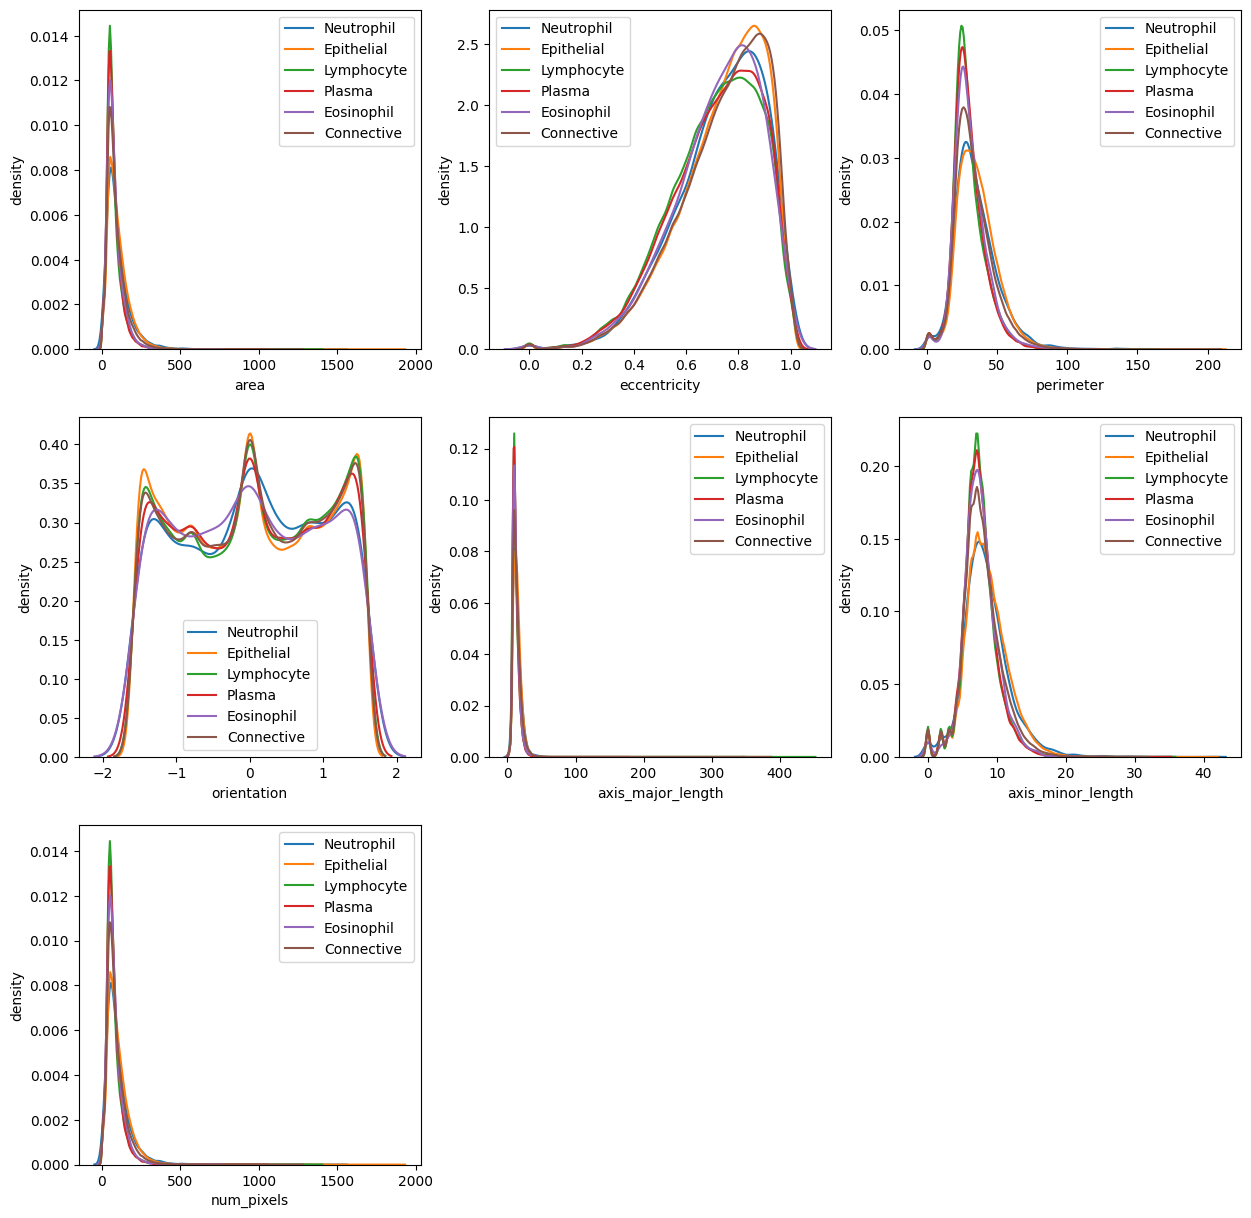

In [ ]:
num_classes = len(df_all['class'].unique())
num_rows = len(properties) // 3
if len(properties) % 3 != 0:
    num_rows += 1
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

axes = axes.flatten()
for i, prop in enumerate(properties):
    # Plot boxplots for each property
    for class_label, data in df_all.groupby('class'):
            sns.kdeplot(data[prop], ax=axes[i], label=f'{class_names[class_label]}')    
    axes[i].set_xlabel(prop)
    axes[i].set_ylabel('density')
    axes[i].legend()

for i in range(len(properties), len(axes)): # to hide empty subplots
    axes[i].axis('off')    

print(class_names)

{1: 'Neutrophil', 2: 'Epithelial', 3: 'Lymphocyte', 4: 'Plasma', 5: 'Eosinophil', 6: 'Connective'}


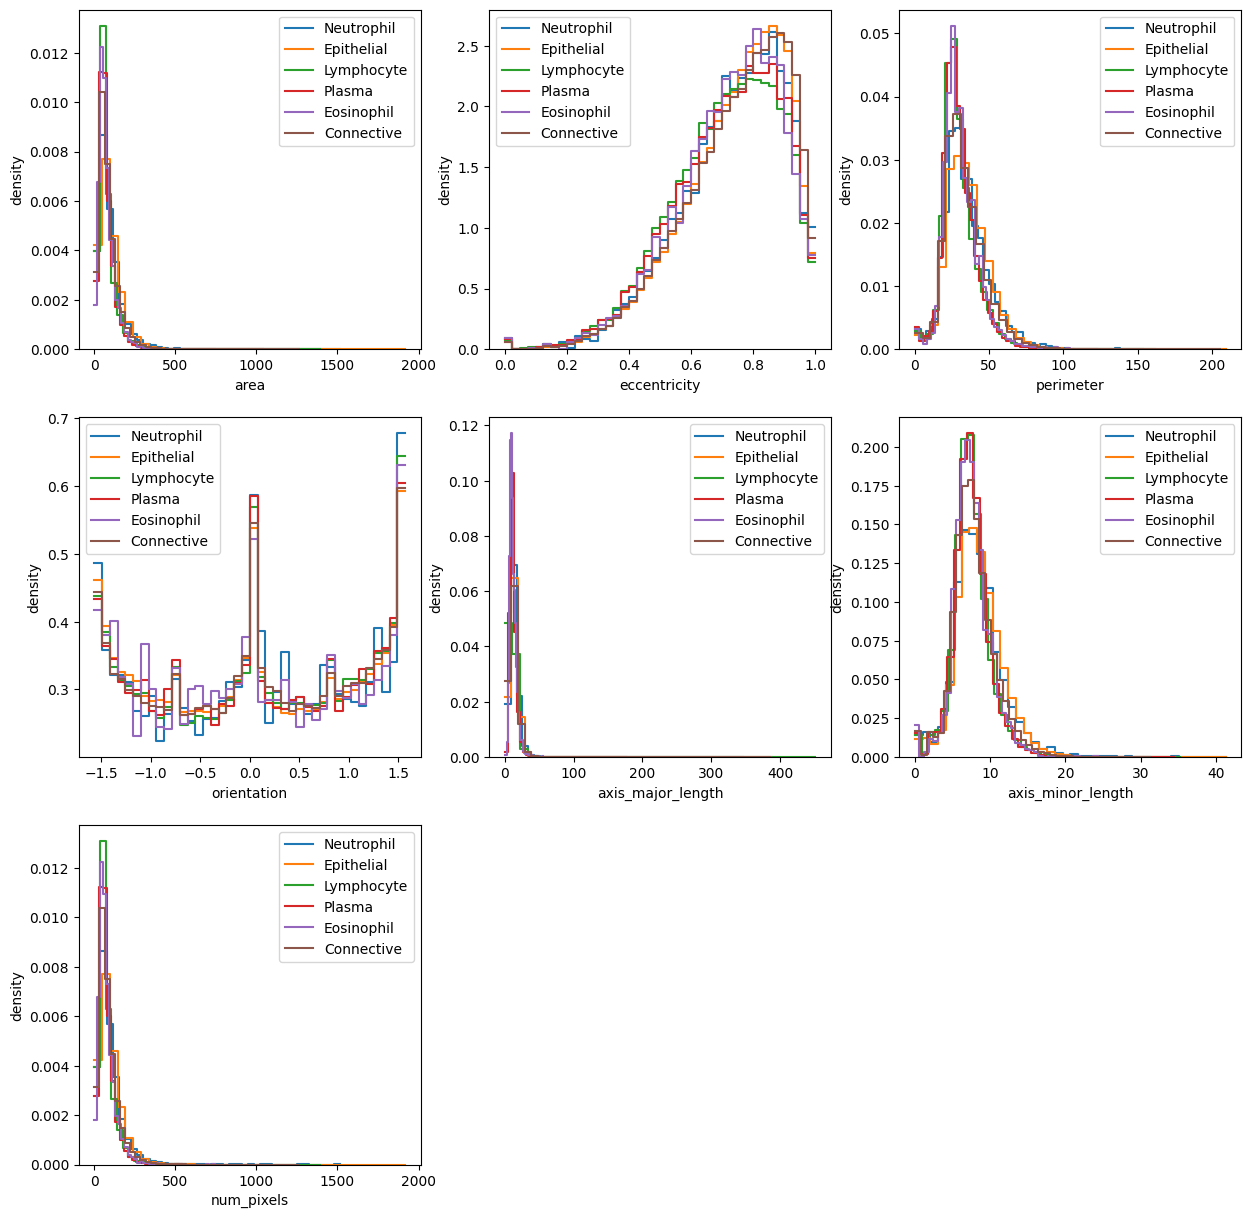

In [ ]:
num_classes = len(df_all['class'].unique())
num_rows = len(properties) // 3
if len(properties) % 3 != 0:
    num_rows += 1
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

axes = axes.flatten()
for i, prop in enumerate(properties):
    # Plot boxplots for each property
    for class_label, data in df_all.groupby('class'):
        sns.histplot(data[prop], ax=axes[i], label=f'{class_names[class_label]}', kde=False, stat='density', common_norm=False, 
                     bins=40, element="step", fill=False) #edgecolor='None', alpha=0.3, 
    axes[i].set_xlabel(prop)
    axes[i].set_ylabel('density')
    axes[i].legend()

for i in range(len(properties), len(axes)): # to hide empty subplots
    axes[i].axis('off')    

print(class_names)

In [ ]:
'''
   Counts from instance map as seen in: https://github.com/TissueImageAnalytics/CoNIC/blob/main/notebooks/data.ipynb
   
   We may notice that there exists more nuclei than in the original Lizard datset. 
   Although we mainly use non-overlapping patches, we choose to extract with overlap at the edge of each image to ensure 
   all pixels are considered without the need for padding.
'''

total_nuclei = 0
total_neutrophil = 0
total_epithelial = 0
total_lymphocyte = 0
total_plasma = 0
total_eosinophil = 0
total_connective = 0
total_list = [total_neutrophil, total_epithelial, total_lymphocyte, total_plasma, total_eosinophil, total_connective]
for idx in range(instances_map.shape[0]):
    patch_inst_map = instances_map[idx]
    patch_class_map = classification_map[idx]
    unique_vals = np.unique(patch_inst_map).tolist()[1:]
    total_nuclei += len(unique_vals)
    # get the counts per class
    for idx2 in range(6):
        patch_class_map_oneclass = patch_class_map == idx2+1
        # subset the instance map
        patch_inst_map_oneclass = patch_inst_map * patch_class_map_oneclass
        unique_vals = np.unique(patch_inst_map_oneclass).tolist()[1:]
        total_list[idx2] += len(unique_vals)

for idx, class_name in class_names.items():
    print(class_name, ":", total_list[idx-1])
    
print("Total :", total_nuclei)

Neutrophil : 5082
Epithelial : 282082
Lymphocyte : 120933
Plasma : 31965
Eosinophil : 3849
Connective : 125950
Total : 569861


In [ ]:
'''
   Counts from counts.csv file as seen in: https://github.com/TissueImageAnalytics/CoNIC/blob/main/notebooks/data.ipynb
    
   We only consider the central 224x224 region for counting.
'''

counts_neutrophil = 0
counts_epithelial = 0
counts_lymphocyte = 0
counts_plasma = 0
counts_eosinophil = 0
counts_connective = 0
for idx in range(counts.shape[0]):
    counts_tmp = counts.iloc[idx]
    counts_neutrophil += counts_tmp['neutrophil']
    counts_epithelial += counts_tmp['epithelial']
    counts_lymphocyte += counts_tmp['lymphocyte']
    counts_plasma += counts_tmp['plasma']
    counts_eosinophil += counts_tmp['eosinophil']
    counts_connective += counts_tmp['connective']

counts_list = [counts_neutrophil, counts_epithelial, counts_lymphocyte, counts_plasma, counts_eosinophil, counts_connective]
for idx, count_type in enumerate(counts_list):
    print(class_names[idx+1], ":", count_type)
    
counts_total = sum(counts_list)
print("Total :", counts_total)

Neutrophil : 4012
Epithelial : 222017
Lymphocyte : 93612
Plasma : 24793
Eosinophil : 2999
Connective : 98783
Total : 446216


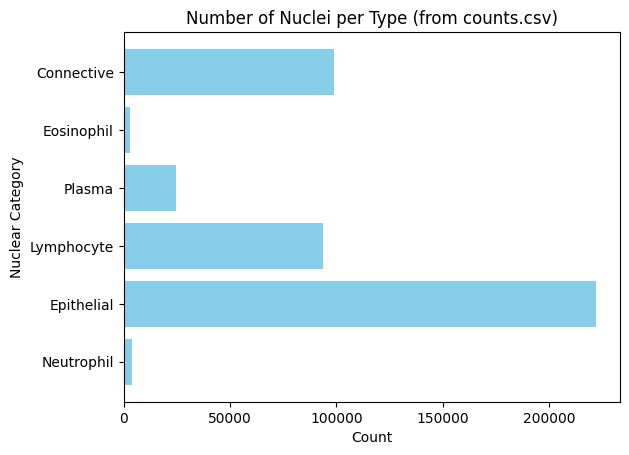

In [ ]:
x_pos = [k for k, v in class_names.items()]

plt.barh(x_pos, counts_list, color="skyblue")
plt.xlabel("Count")
plt.ylabel("Nuclear Category")
plt.title("Number of Nuclei per Type (from counts.csv)")
plt.yticks(x_pos, class_names.values())
plt.show()